# Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sys import path
from copy import deepcopy
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
warnings.filterwarnings("ignore")

model_dir = 'sample_code_submission/'
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'


path.append(model_dir) 
path.append(problem_dir)
path.append(score_dir)
path.append("../Data_Generator")

from data_io import load_data, show_data_statistics, write


data_name = 'fair_universe_challenge'
data_dir = 'sample_data' 


train_sets, test_sets, settings = load_data(data_dir, load_settings=True)



###-------------------------------------###
### Data Loading
###-------------------------------------###

[*] data dir :  sample_data
[*] train data dir :  sample_data/train/data
[*] train labels dir :  sample_data/train/labels
[*] test data dir :  sample_data/test/data
[*] test labels dir :  sample_data/test/labels
[*] settings dir :  sample_data/settings
[+] train data dir found
[+] train labels dir found
[+] test data dir found
[+] test labels dir found
[+] settings dir found
[+] 6 train and test sets found
---------------------------------
[+] Train and Test data loaded!
---------------------------------




In [2]:
from model import Model
from metric import auc_metric, bac_metric

model_settings = [
    {"display_name" : "NB plain", "model_name": "NB", "preprocessing" : False, "data_augmentation" : False},
    {"display_name" : "LDA plain", "model_name": "LDA", "preprocessing" : False, "data_augmentation" : False},
    {"display_name" : "RR plain", "model_name": "RR", "preprocessing" : False, "data_augmentation" : False},
]

#---------------------------------
# Load Data
#---------------------------------
# Train set
X_Trains = [train_set["data"] for train_set in train_sets]
Y_Trains = [train_set["labels"] for train_set in train_sets]

# Test set
X_Tests = [test_set["data"] for test_set in test_sets]
Y_Tests = [test_set["labels"] for test_set in test_sets]


print("############################################")
print("### Training Program")
print("############################################")

#---------------------------------
# Loop over model settings
#---------------------------------
results = []
for model_setting in model_settings:

    print("\n--------------------------------------------")
    print("[*] Model : {} --- Preprocessing: {} --- Data Augmentation: {}".format(model_setting["model_name"], model_setting["preprocessing"], model_setting["data_augmentation"]))
    print("--------------------------------------------")
    #---------------------------------
    # Predictions Directory
    #---------------------------------
    # result directory 
    predictions_dir = os.path.join(result_dir, model_setting["model_name"])
    # create result directory if not created
    if not os.path.exists(predictions_dir):
        os.mkdir(predictions_dir) 

    #---------------------------------
    # Loop over datasets
    #---------------------------------
    trained_models = []
    Y_hat_trains, Y_hat_score_trains = [], []
    Y_hat_tests, Y_hat_score_tests = [], []
    auc_trains, auc_tests, bac_trains, bac_tests = [],[],[],[]
    for index, _ in enumerate(X_Trains):

        print("\n\tDataset : {}".format(index+1))
        print("\t----------------")

        #---------------------------------
        # Constant predictions for Constatnt model
        #---------------------------------
        if model_setting["model_name"] == "Constant":

            # Get Predictions
            print("\t[*] Get Predictions")
            Y_hat_trains.append(np.zeros(X_Trains[index].shape[0]))
            Y_hat_tests.append(np.zeros(X_Tests[index].shape[0]))
            
            # Get Scores
            print("\t[*] Get Scores")
            Y_hat_score_trains.append(np.zeros(X_Trains[index].shape[0]))
            Y_hat_score_tests.append(np.zeros(X_Tests[index].shape[0]))

            trained_models.append(None)

            
        #---------------------------------
        # All other models
        #---------------------------------
        else:
            # model_name 
            trained_model_name = model_dir + model_setting["model_name"]

            #---------------------------------
            # Load Model
            #---------------------------------
            print("\t[*] Loading Model")
            model = Model(
                model_setting["model_name"],
                X_Trains[index],
                Y_Trains[index],
                X_Tests[index],
                model_setting["preprocessing"],
                model_setting["data_augmentation"]
            )
            # Load Trained Model 
            # model = model.load(trained_model_name) 

            #---------------------------------
            # Train Model
            #---------------------------------
            # Train model if not trained
            print("\t[*] Training Model")
            if not(model.is_trained):
                model.fit() 

            #---------------------------------
            # Get Predictions
            #---------------------------------
            print("\t[*] Get Predictions")
            Y_hat_trains.append(model.predict())
            Y_hat_tests.append(model.predict())
            
            #---------------------------------
            # Get Scores/Proba
            #---------------------------------
            print("\t[*] Get Scores")
            Y_hat_score_trains.append(model.decision_function())
            Y_hat_score_tests.append(model.decision_function())

            trained_models.append(model)

        #---------------------------------
        # Get Metric Scores
        #---------------------------------
        print("\t[*] Computing Scores using AUC and BAC")
        auc_trains.append(round(auc_metric(Y_Trains[index], Y_hat_score_trains[-1]), 2))
        auc_tests.append(round(auc_metric(Y_Tests[index], Y_hat_score_tests[-1]), 2))
        bac_trains.append(round(bac_metric(Y_Trains[index], Y_hat_trains[-1]), 2))
        bac_tests.append(round(bac_metric(Y_Tests[index], Y_hat_tests[-1]), 2))


        #---------------------------------
        # Save Predictions
        #---------------------------------
        print("\t[*] Saving Predictions and Scores")
        # prediction file name
        prediction_name_train = os.path.join(predictions_dir, "train_"+ str(index+1) + ".predictions")
        prediction_name_test = os.path.join(predictions_dir, "test_"+ str(index+1) + ".predictions")

        # score file name
        score_name_train = os.path.join(predictions_dir, "train_"+ str(index+1) + ".scores")
        score_name_test = os.path.join(predictions_dir, "test_"+ str(index+1) + ".scores")
        
        # save prediction
        write(prediction_name_train, Y_hat_score_trains[-1])
        write(prediction_name_test, Y_hat_score_tests[-1])

        # save score
        write(score_name_train, Y_hat_score_trains[-1])
        write(score_name_test, Y_hat_score_tests[-1])
    


    
    results.append({
        "trained_models" : trained_models,
        "Y_hat_trains" : Y_hat_trains,
        "Y_hat_tests" : Y_hat_tests,
        "Y_hat_score_trains" : Y_hat_score_trains,
        "Y_hat_score_tests" : Y_hat_score_tests,
        "auc_trains" : auc_trains,
        "auc_tests" : auc_tests,
        "bac_trains" : bac_trains,
        "bac_tests" : bac_tests,
    })

############################################
### Training Program
############################################

--------------------------------------------
[*] Model : NB --- Preprocessing: False --- Data Augmentation: False
--------------------------------------------

	Dataset : 1
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scores

	Dataset : 2
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scores

	Dataset : 3
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scores

	Dataset : 4
	----------------
	[*] Loading Model
	[*] Training Model
	[*] Get Predictions
	[*] Get Scores
	[*] Computing Scores using AUC and BAC
	[*] Saving Predictions and Scor

In [10]:
def visualize_decision(fig, ax, title, model, cmap):

    grid_resolution=100
    eps=.02
    plot_method="contourf"


    x0_min, x0_max = (-8 - eps), (8+ eps)
    x1_min, x1_max = (-8 - eps), (8+ eps)
    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution),
    )

    X_grid = np.c_[xx0.ravel(), xx1.ravel()]

    if model.model_name in ["NB"]:
        response = model.clf.predict_proba(X_grid)[:, 1]
        # Transform with log
        epsilon = 0.001
        response = -np.log((1/response+epsilon)-1)
    else:
        response = model.clf.decision_function(X_grid)

    

    response=response.reshape(xx0.shape)

    ax.set_title(title)
    plot_func = getattr(ax, plot_method)
    # surface_ = plot_func(xx0, xx1, response, cmap=cmap, alpha=0.5)
   
    # plt.contourf(xx0, xx1, response, 20, cmap='RdGy')
    im = plt.imshow(response, extent=[-8, 8, -8, 8], origin='lower', cmap=cmap, alpha=0.5)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    ax.axhline(y=0, color='g', linestyle='--')
    ax.axvline(x=0, color='g', linestyle='--')
    

def visualize_scatter(ax, data_set):

    data = data_set["data"]
    labels = data_set["labels"]

    signal_mask = labels == 1
    background_mask = labels == 0

    ax.scatter(data[background_mask]["x1"],data[background_mask]["x2"], c='b', edgecolors="k", alpha=0.7)
    ax.scatter(data[signal_mask]["x1"],data[signal_mask]["x2"], c='r', edgecolors="k", alpha=0.7)


def visualize_decicion_boundary(name, settings, result, train_sets, test_sets, cmap):

    for index, model in enumerate(result["trained_models"]):

        fig = plt.figure(figsize=(20, 7))

        # decision boundry
        ax = plt.subplot(1, 3, 1)
        visualize_decision(fig, ax, "Decision Boundry", model, cmap)
        
      
        # train decision boundry
        ax = plt.subplot(1, 3, 2)
        visualize_decision(fig, ax, "Train Data", model, cmap)
        visualize_scatter(ax, train_sets[index])
       
        # test decision boundry
        ax = plt.subplot(1, 3, 3)
        visualize_decision(fig, ax, "Test Data", model, cmap)
        visualize_scatter(ax, test_sets[index])
       


        train_auc = round(np.mean(result["auc_trains"]),2)
        test_auc = round(np.mean(result["auc_tests"]),2)
        train_bac = round(np.mean(result["bac_trains"]),2)
        test_bac = round(np.mean(result["bac_tests"]),2)
        title = "{}\nTrain: AUC:{} BAC:{} --- Test: AUC:{} BAC:{}".format(name, train_auc, train_bac, test_auc, test_bac)
        plt.suptitle(title, fontsize=15)
        plt.show()
        
        break




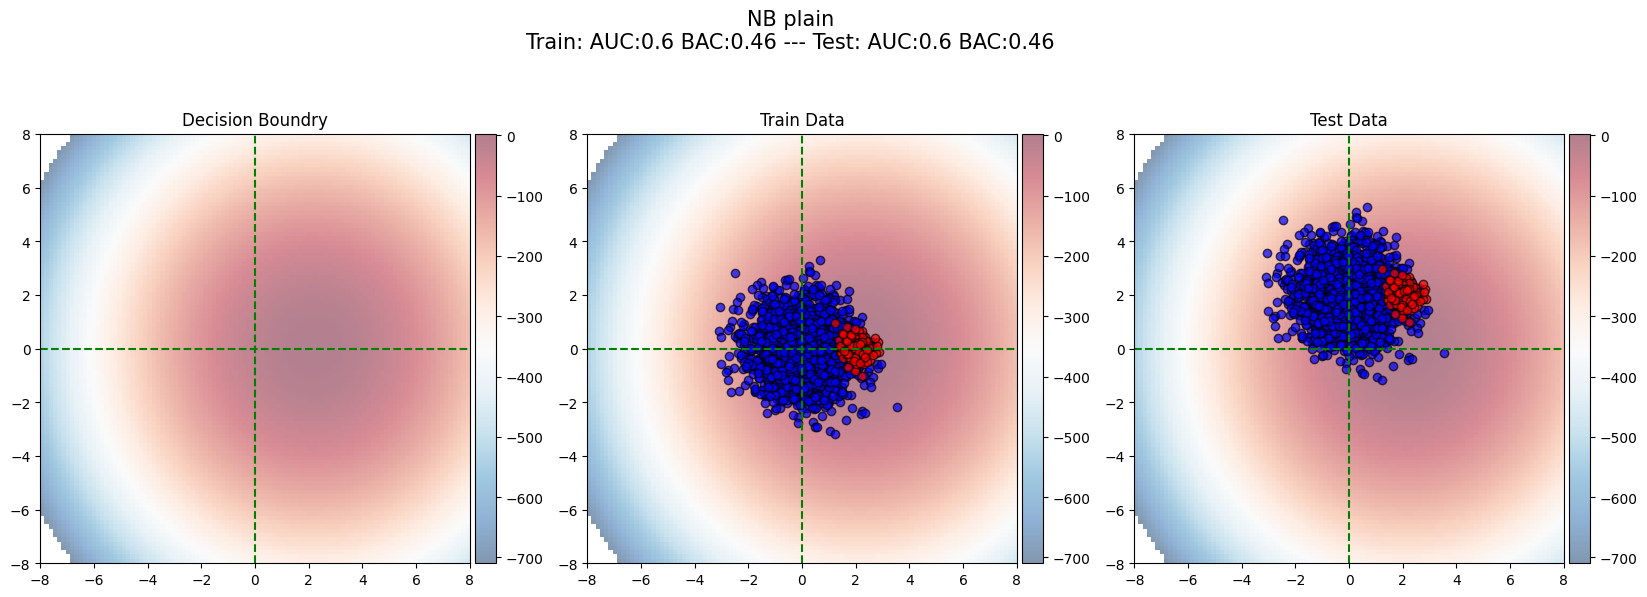

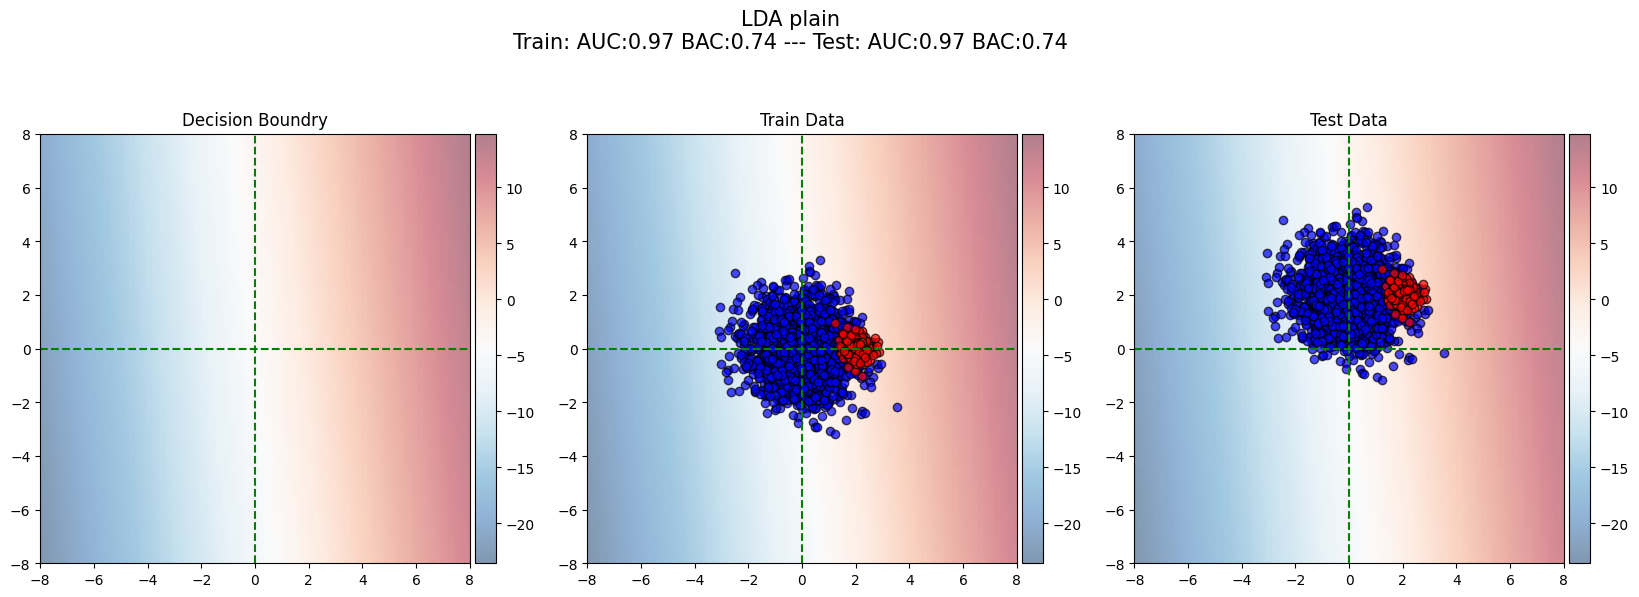

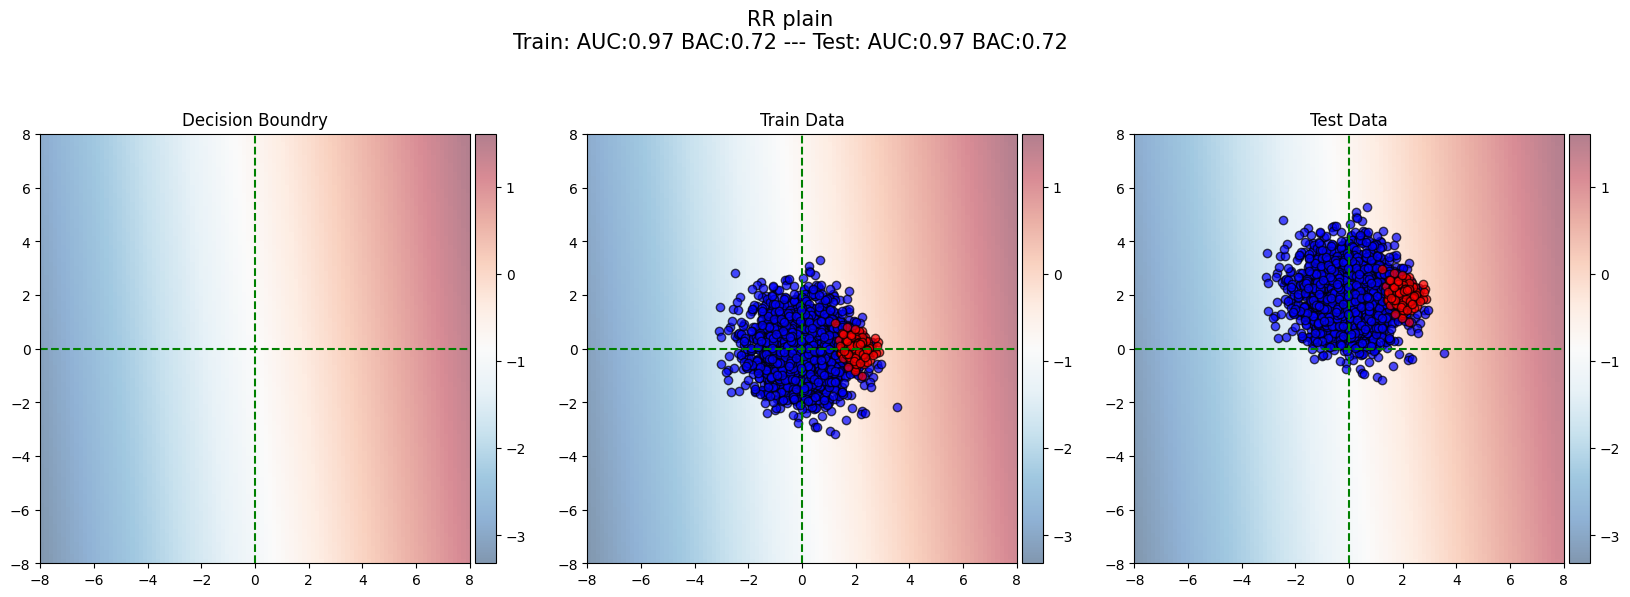

In [11]:
for model_s, result in zip(model_settings, results):
    visualize_decicion_boundary(model_s["display_name"], settings, result, train_sets, test_sets, 'RdBu_r')